In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Load data 
path = 'jena_climate_2009_2016_test.csv'
df = pd.read_csv(path, parse_dates=True, index_col='Date Time')
xt = df['T (degC)'].reset_index(drop=True).astype('float32')

In [3]:
N = len(xt)
n_test = 1440 
assert N > n_test + 400, "Series too short, redo again"

In [4]:
# Build sliding-window sequences
window = 288  
values = xt.values

cut_target = N - n_test  
last_trainval_k = cut_target - 1 - window  
trainval_ks = np.arange(0, last_trainval_k + 1, dtype=int)
test_ks = np.arange(cut_target - window, N - window, dtype=int)  

def build_Xy_from_indices(vals, ks, window):
    X = np.stack([vals[k:k+window] for k in ks], axis=0)
    y = np.stack([vals[k+window] for k in ks], axis=0)
    return X[..., None], y  

X_trainval_raw, y_trainval_raw = build_Xy_from_indices(values, trainval_ks, window)
X_test_raw, y_test_raw = build_Xy_from_indices(values, test_ks, window)

In [5]:
# Train/Val split 
n_trainval = len(X_trainval_raw)
val_fraction = 0.2
n_val = int(np.floor(n_trainval * val_fraction))
n_train = n_trainval - n_val

X_train_raw = X_trainval_raw[:n_train]
y_train_raw = y_trainval_raw[:n_train]
X_val_raw   = X_trainval_raw[n_train:]
y_val_raw   = y_trainval_raw[n_train:]

In [6]:
# Standardize using *training* statistics (z-score)
mean_train = y_train_raw.mean()  
std_train  = y_train_raw.std() + 1e-8

def zscore(arr):
    return (arr - mean_train) / std_train

def unzscore(arr):
    return arr * std_train + mean_train

X_train = zscore(X_train_raw)
y_train = zscore(y_train_raw)
X_val   = zscore(X_val_raw)
y_val   = zscore(y_val_raw)
X_test  = zscore(X_test_raw) 

In [7]:
# RNN model
tf.random.set_seed(42)
model = keras.Sequential([
    layers.Input(shape=(window, 1)),
    layers.GRU(64, return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse',
              metrics=['mse'])

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=128,
    verbose=0,
    callbacks=[early]
)

In [8]:
# Predict on the test set and invert scaling
y_pred_z = model.predict(X_test, verbose=0).squeeze()
y_pred = unzscore(y_pred_z)
y_true = y_test_raw.squeeze()

In [9]:
# Persistence baseline (y_hat_t = y_{t-1}) 
y_persist = X_test_raw[:, -1, 0]

In [10]:
# MSEs on the test (in Celsius)
mse_model = mean_squared_error(y_true, y_pred)
mse_persist = mean_squared_error(y_true, y_persist)

print(f"Test MSE (RNN model): {mse_model:.4f} °C²")
print(f"Test MSE (Persistence): {mse_persist:.4f} °C²")
improvement = 100.0 * (mse_persist - mse_model) / mse_persist
print(f"Relative improvement over persistence: {improvement:.2f}%")

Test MSE (RNN model): 0.1233 °C²
Test MSE (Persistence): 0.0440 °C²
Relative improvement over persistence: -180.44%


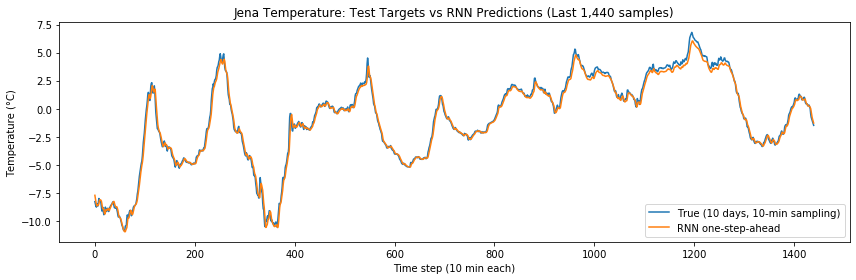

In [11]:
# Plot 1440 reserved true vs one-step-ahead predictions
plt.figure(figsize=(12, 4))
plt.plot(y_true, label='True (10 days, 10-min sampling)')
plt.plot(y_pred, label='RNN one-step-ahead')
plt.title('Jena Temperature: Test Targets vs RNN Predictions (Last 1,440 samples)')
plt.xlabel('Time step (10 min each)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.show()